# Prueba de distintos modelos de predicción

En este notebook se prueban tres algoritmos de clasificación:

* Random Forest
* Regresión logística multiclase
* K vecinos más próximos

Con el objetivo de encontrar el que mejor prediga.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## 1. Obtención del dataframe y tratamiento de las variables

Importamos el dataframe

In [88]:
df_pre = pd.read_excel('TABLA_MODELO.xlsx', sheetname='PLANTILLA')

Lo filtramos:

In [89]:
df_filt = df_pre[['ANIO', 
              'EQUIPO_1', 
              'RANKING_1', 
              'EQUIPO_2', 
              'RANKING_2',
              'POR_VIC1',
              'POR_VIC2',
              'ATAQUE_1',
              'MEDIO_1',
              'DEFENSA_1',
              'ATAQUE_2',
              'MEDIO_2',
              'DEFENSA_2',
              'RESULTADO_CUOTAS']]

Generamos variables en diferencias:

In [90]:
df_filt['DIF_AT_DEF'] = df_filt['ATAQUE_1'] - df_filt['DEFENSA_2']
df_filt['DIF_MED'] = df_filt['MEDIO_1'] - df_filt['MEDIO_2']
df_filt['DIF_DEF_AT'] = df_filt['DEFENSA_1'] - df_filt['ATAQUE_2']
df_filt['DIF_RANK'] = df_filt['RANKING_2'] - df_filt['RANKING_1']
df_filt['DIF_VD_TRAN'] = df_filt['POR_VIC1'] - df_filt['POR_VIC2']
df_filt['RESULTADO'] = df_filt['RESULTADO_CUOTAS']

In [91]:
df = df_filt.copy()

#### Celda de elección de parámetros

In [92]:
anios = [2015, 2016, 2017, 2018]
tipo_partido = ['AMISTOSO', 'OFICIAL']
variables_modelo = ['DIF_AT_DEF', 'DIF_MED', 'DIF_DEF_AT', 'DIF_RANK','DIF_VD_TRAN', 'RESULTADO']
factor_variable1 = 10
factor_variable2 = 10
factor_variable3 = 10
factor_variable4 = 1
factor_variable5 = 1
testsize = 0.15

#### Tratamiento del dataframe

In [93]:
# Filtro de año

df = df[df['ANIO'].isin(anios)]

In [94]:
# Aplicación de factores de las variables

df[variables_modelo[0]] = df[variables_modelo[0]] * factor_variable1
df[variables_modelo[1]] = df[variables_modelo[1]] * factor_variable2
df[variables_modelo[2]] = df[variables_modelo[2]] * factor_variable3
df[variables_modelo[3]] = df[variables_modelo[3]] * factor_variable4
df[variables_modelo[4]] = df[variables_modelo[4]] * factor_variable5



In [95]:
# Nos quedamos con las columnas de las variables del modelo

df = df[variables_modelo]

In [96]:
df.head(5)

,DIF_AT_DEF,DIF_MED,DIF_DEF_AT,DIF_RANK,DIF_VD_TRAN,RESULTADO
0,140,130,140,66,0.571429,1
1,-50,-80,-100,-25,-0.416667,-1
2,-10,0,-20,1,-0.404762,0
3,0,-10,10,9,-0.261905,0
4,-30,-40,-60,-56,-0.571429,-1


## 2. Regresión logística

#### Dividimos en train y test set

In [97]:
from sklearn.model_selection import train_test_split

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
                                                    df.drop('RESULTADO',axis=1), 
                                                    df['RESULTADO'], 
                                                    test_size=testsize)

#### Entrenamos

In [98]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
logmodel.fit(X_train_LR,y_train_LR,)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

#### Predecimos

In [99]:
predictions_LR = logmodel.predict(X_test_LR)
predictions_LR

array([ 0,  0,  0,  0,  0,  0,  1,  1,  0,  0, -1,  0,  1,  1,  1,  0,  0,
       -1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  1,  1, -1,  0,  1,  0,  0,  1,  1,  0,  0,  1,  0, -1,  0,
        1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  0,  0,  1,  1,
        0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,  0, -1, -1,  0,  0,  1,
        0,  0,  1,  1,  0,  0, -1,  1,  0, -1, -1,  0,  1,  0], dtype=int64)

#### Performance

In [100]:
from sklearn.metrics import classification_report,confusion_matrix

In [101]:
print(classification_report(y_test_LR,predictions_LR))

             precision    recall  f1-score   support

         -1       0.56      0.71      0.63         7
          0       0.82      0.73      0.77        55
          1       0.73      0.81      0.77        37

avg / total       0.77      0.76      0.76        99



In [102]:
confusion_matrix(y_test_LR, predictions_LR)

array([[ 5,  2,  0],
       [ 4, 40, 11],
       [ 0,  7, 30]], dtype=int64)

## 3. Random Forest

#### Dividimos en train y test set

In [103]:
from sklearn.model_selection import train_test_split

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(
                                                    df.drop('RESULTADO',axis=1), 
                                                    df['RESULTADO'], 
                                                    test_size=testsize)

#### Entrenamos

In [104]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_RF, y_train_RF)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Predecimos

In [105]:
predictions_RF = rfc.predict(X_test_RF)
predictions_RF

array([ 1,  1,  0,  1,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,
       -1, -1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1, -1, -1,  0,
        1,  1,  0,  0,  1,  1,  0,  1,  1, -1,  0,  1,  0,  1, -1,  0,  0,
        0, -1,  0,  1,  0,  1,  0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  1,  0,  0, -1,  0,  1,  0,  0, -1,  1,  0,  0,  0], dtype=int64)

#### Performance

In [106]:
from sklearn.metrics import classification_report,confusion_matrix

In [107]:
print(classification_report(y_test_RF,predictions_RF))

             precision    recall  f1-score   support

         -1       0.70      0.70      0.70        10
          0       0.71      0.82      0.76        50
          1       0.81      0.64      0.71        39

avg / total       0.75      0.74      0.74        99



## 4. KNN Neighbors

#### Escalamos las variables

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('RESULTADO',axis=1))
scaled_features = scaler.transform(df.drop('RESULTADO',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])

In [109]:
df_prueba = df.sample()
df_prueba

,DIF_AT_DEF,DIF_MED,DIF_DEF_AT,DIF_RANK,DIF_VD_TRAN,RESULTADO
344,-30,-80,-80,-3,-0.324786,0


In [110]:
scaler.transform(df_prueba.drop('RESULTADO',axis=1))

array([[-0.77579061, -1.32133031, -0.9891474 , -0.14369965, -0.93789044]])

#### Dividimos en train y test set

In [111]:
from sklearn.model_selection import train_test_split

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(
                                                    scaled_features, 
                                                    df['RESULTADO'], 
                                                    test_size=testsize)

#### Elegimos valor de K -> Elbow method

In [112]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_KNN,y_train_KNN)
    pred_i = knn.predict(X_test_KNN)
    error_rate.append(np.mean(pred_i != y_test_KNN))

Text(0,0.5,'Error Rate')

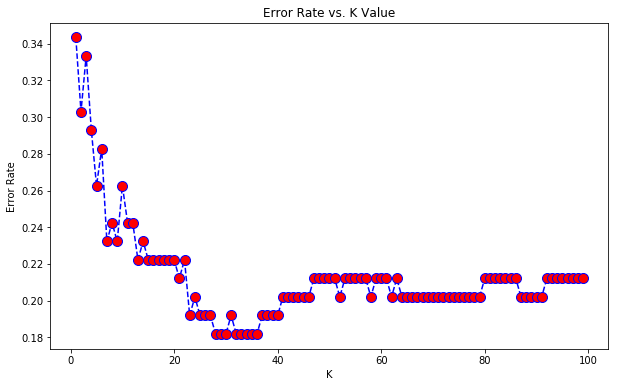

In [113]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### Entrenamos

In [120]:
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_KNN,y_train_KNN)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=22, p=2,
           weights='uniform')

#### Predecimos

In [121]:
predictions_KNN = knn.predict(X_test_KNN)

#### Performance

In [122]:
from sklearn.metrics import classification_report,confusion_matrix

In [123]:
print(classification_report(y_test_KNN,predictions_KNN))

             precision    recall  f1-score   support

         -1       0.67      0.44      0.53         9
          0       0.75      0.89      0.82        55
          1       0.86      0.69      0.76        35

avg / total       0.78      0.78      0.77        99



## 5. Resumen de los tres modelos

In [124]:
print("**************   Regresión Logística   *************")
print("")
print(classification_report(y_test_LR,predictions_LR))
print('****************************************************')
print("")
print("*****************   Random Forest   ****************")
print("")
print(classification_report(y_test_RF,predictions_RF))
print('****************************************************')
print("")
print("*****************   KNN Neighbors   ****************")
print("")
print(classification_report(y_test_KNN,predictions_KNN))
print('****************************************************')

**************   Regresión Logística   *************

             precision    recall  f1-score   support

         -1       0.56      0.71      0.63         7
          0       0.82      0.73      0.77        55
          1       0.73      0.81      0.77        37

avg / total       0.77      0.76      0.76        99

****************************************************

*****************   Random Forest   ****************

             precision    recall  f1-score   support

         -1       0.70      0.70      0.70        10
          0       0.71      0.82      0.76        50
          1       0.81      0.64      0.71        39

avg / total       0.75      0.74      0.74        99

****************************************************

*****************   KNN Neighbors   ****************

             precision    recall  f1-score   support

         -1       0.67      0.44      0.53         9
          0       0.75      0.89      0.82        55
          1       0.86      0.69  